## Random sample imputation

Replacing of NA by random sampling for categorical variables is exactly the same as for numerical variables.

Random sampling consist of taking a random observation from the pool of available observations of the variable, that is, from the pool of available categories, and using that randomly extracted value to fill the NA. In Random Sampling one takes as many random observations as missing values are present in the variable.

By random sampling observations of the present categories, we guarantee that the frequency of the different categories/labels within the variable is preserved.


### Assumptions

Random sample imputation has the assumption that the data are missing completely at random (MCAR). If this is the case, it makes sense to substitute the missing values, by values extracted from the original variable distribution/ category frequency. 


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets

### Limitations

- Randomness
- May distort the relation of the labels with other variables within the dataset

See lecture "Replacing NA by random sampling" in the section "Engineering missing values in numerical variables" for a discussion on the effect of randomness and why it is important to consider it.

===============================================================================

## Real Life example: 

### Predicting Sale Price of Houses

The problem at hand aims to predict the final sale price of homes based on different explanatory variables describing aspects of residential homes. Predicting house prices is useful to identify fruitful investments, or to determine whether the price advertised for a house is over or underestimated, before making a buying judgment.

=============================================================================

In the following cells, I will demonstrate NA imputation by random sampling using the House Price datasets from Kaggle.

If you haven't downloaded the datasets yet, in the lecture "Guide to setting up your computer" in section 1, you can find the details on how to do so.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

# for regression problems
from sklearn.linear_model import LinearRegression, Ridge

# to split and standarize the datasets
from sklearn.model_selection import train_test_split

# to evaluate regression models
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

### House Price dataset

In [2]:
# let's load the dataset with a few columns for the demonstration
cols_to_use = ['BsmtQual', 'FireplaceQu', 'GarageType', 'SalePrice']

data = pd.read_csv('houseprice.csv', usecols=cols_to_use)

# let's inspect the percentage of missing values in each variable
data.isnull().mean().sort_values(ascending=True)

SalePrice      0.000000
BsmtQual       0.025342
GarageType     0.055479
FireplaceQu    0.472603
dtype: float64

The variables BsmtQual and GarageType contain only a few observations with NA (2.5 and 5 %, respectively), therefore, replacing those observations by random sampling the available labels is a good approach. 

On the other hand, the variable FireplaceQu, contains missing data in  almost half of the observations. Therefore, replacing those by random sampling may quite likely distort the relationship of the different labels within the variable with the sale price. In addition, if so many observations contain missing values, it has to be for a reason, so we would be better off capturing missingness somehow. In future lectures, I will show how to capture missingness in categorical variables.

### Imputation important

Imputation has to be done over the training set, and then propagated to the test set. This means that the random sampling of categories should be done from the training set, and used to replace NA both in train and test sets.

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[['BsmtQual', 'FireplaceQu', 'GarageType']],
                                                    data.SalePrice,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [4]:
# let's create a variable to replace NA with the most frequent label or a random sample
# make sure you understand every line of code.
# If unsure, run them separately in a cell in the notebook until you familiarise with the output
# of each line

def impute_na(df_train, df_test, variable):
    # get the most frequent label and replace NA in train and test set
    most_frequent_category = df_train.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    df_train[variable+'_frequent'] = df_train[variable].fillna(most_frequent_category)
    df_test[variable+'_frequent'] = df_test[variable].fillna(most_frequent_category)
    
    # random sampling
    df_train[variable+'_random'] = df_train[variable]
    df_test[variable+'_random'] = df_test[variable]
    
    # extract the random sample to fill the na
    random_sample_train = df_train[variable].dropna().sample(df_train[variable].isnull().sum(), random_state=0)
    random_sample_test = df_train[variable].dropna().sample(df_test[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample_train.index = df_train[df_train[variable].isnull()].index
    random_sample_test.index = df_test[df_test[variable].isnull()].index
    
    df_train.loc[df_train[variable].isnull(), variable+'_random'] = random_sample_train
    df_test.loc[df_test[variable].isnull(), variable+'_random'] = random_sample_test

In [5]:
# and let's replace the NA
for variable in ['BsmtQual', 'FireplaceQu', 'GarageType',]:
    impute_na(X_train, X_test, variable)

In [6]:
# let's check if the values were completed
X_train.isnull().sum()

BsmtQual                 24
FireplaceQu             478
GarageType               54
BsmtQual_frequent         0
BsmtQual_random           0
FireplaceQu_frequent      0
FireplaceQu_random        0
GarageType_frequent       0
GarageType_random         0
dtype: int64

In [7]:
X_train.head()

,BsmtQual,FireplaceQu,GarageType,BsmtQual_frequent,BsmtQual_random,FireplaceQu_frequent,FireplaceQu_random,GarageType_frequent,GarageType_random
64,Gd,NaN,Attchd,Gd,Gd,Gd,Gd,Attchd,Attchd
682,Gd,Gd,Attchd,Gd,Gd,Gd,Gd,Attchd,Attchd
960,TA,NaN,NaN,TA,TA,Gd,TA,Attchd,Attchd
1384,TA,NaN,Detchd,TA,TA,Gd,TA,Detchd,Detchd
1100,TA,NaN,Detchd,TA,TA,Gd,Gd,Detchd,Detchd


In [8]:
# let's check that the 2 ways of replacing NA did not lead to the same variable:

X_train.FireplaceQu_frequent.equals(X_train.FireplaceQu_random)

False

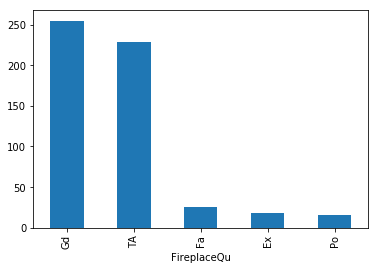

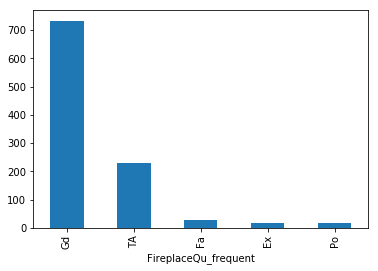

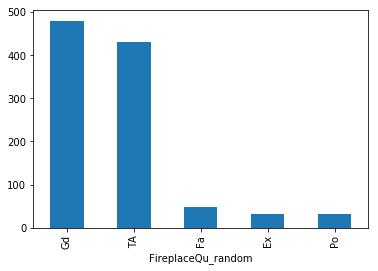

In [9]:
# let's see how the different imputation methods affect the distribution of the labels within the variable

for col in ['FireplaceQu', 'FireplaceQu_frequent', 'FireplaceQu_random']:
    X_train.groupby([col])[col].count().sort_values(ascending=False).plot.bar()
    plt.show()

From the 3 plots above, we observe that the replacement by the most frequent category increases the proportion of houses with the most frequent label quite dramatically (compare plots 1 and 2). We have seen the effect of adding all missing observation within the most frequent label in the previous lecture.

On the other hand, replacing missing observations with random samples, preserves the proportion of observations within each of the categories(compare plots 1 and 3).

In [10]:
# let's transform the categories into numbers quick and dirty so we can use them in scikit-learn
# the below function numbers the labels from 0 to n, n being the number of different labels 
#  within the variable

for col in ['BsmtQual_random', 'FireplaceQu_random', 'GarageType_random',]:
    labels_dict = {k:i for i, k in enumerate(X_train[col].unique(), 0)}
    X_train.loc[:, col] = X_train.loc[:, col].map(labels_dict )
    X_test.loc[:, col] = X_test.loc[:, col].map(labels_dict)

for col in ['BsmtQual_frequent', 'FireplaceQu_frequent', 'GarageType_frequent',]:
    labels_dict = {k:i for i, k in enumerate(X_train[col].unique(), 0)}
    X_train.loc[:, col] = X_train.loc[:, col].map(labels_dict )
    X_test.loc[:, col] = X_test.loc[:, col].map(labels_dict)

### Linear Regression

In [11]:
# Let's evaluate the performance of Linear Regression

linreg = LinearRegression()
linreg.fit(X_train[['BsmtQual_frequent', 'FireplaceQu_frequent', 'GarageType_frequent']], y_train)
print('Train set frequent imputation')
pred = linreg.predict(X_train[['BsmtQual_frequent', 'FireplaceQu_frequent', 'GarageType_frequent']])
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set frequent imputation')
pred = linreg.predict(X_test[['BsmtQual_frequent', 'FireplaceQu_frequent', 'GarageType_frequent']])
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

linreg = LinearRegression()
linreg.fit(X_train[['BsmtQual_random', 'FireplaceQu_random', 'GarageType_random']], y_train)
print('Train set random imputation')
pred = linreg.predict(X_train[['BsmtQual_random', 'FireplaceQu_random', 'GarageType_random']])
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set random imputation')
pred = linreg.predict(X_test[['BsmtQual_random', 'FireplaceQu_random', 'GarageType_random']])
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()


Train set frequent imputation
Linear Regression mse: 5508120196.474013
Test set frequent imputation
Linear Regression mse: 6364449797.852686

Train set random imputation
Linear Regression mse: 5837701371.356659
Test set random imputation
Linear Regression mse: 6456070592.706035



The performance of the linear regression models built on the datasets which missing values were replaced by the frequent label or by random imputation is roughly the same.

Keep in mind that a different random selection of labels may lead to better or worse performances. Go ahead and change the random_state in the impute_na function, and build different linear regressions for comparison.

### Relationship between labels and other variables after imputation of NA

In [12]:
temp = pd.concat([X_train, y_train], axis=1)
temp.head()

,BsmtQual,FireplaceQu,GarageType,BsmtQual_frequent,BsmtQual_random,FireplaceQu_frequent,FireplaceQu_random,GarageType_frequent,GarageType_random,SalePrice
64,Gd,NaN,Attchd,0,0,0,0,0,0,219500
682,Gd,Gd,Attchd,0,0,0,0,0,0,173000
960,TA,NaN,NaN,1,1,0,1,0,0,116500
1384,TA,NaN,Detchd,1,1,0,1,1,1,105000
1100,TA,NaN,Detchd,1,1,0,0,1,1,60000


In [13]:
# let's map the numbers to the original labels (Gd was mapped to zero)

temp['FireplaceQu_random'] = temp['FireplaceQu_random'].map({0:'Gd'})
temp['FireplaceQu_frequent'] = temp['FireplaceQu_frequent'].map({0:'Gd'})

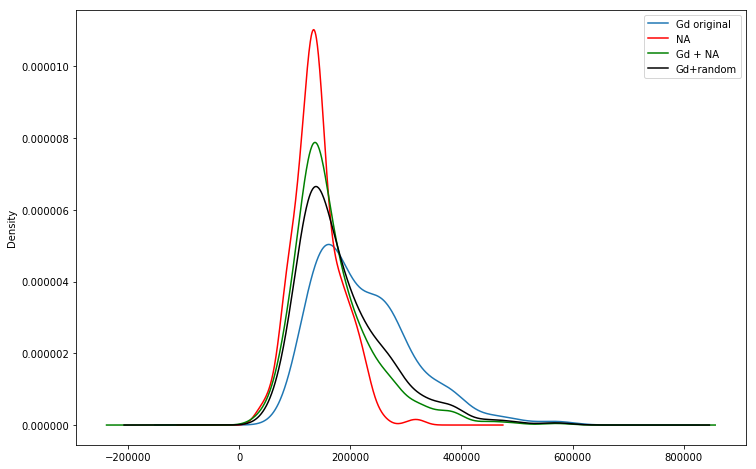

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
temp[temp.FireplaceQu=='Gd']['SalePrice'].plot(kind='kde', ax=ax)
temp[temp.FireplaceQu.isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')
temp[temp.FireplaceQu_frequent=='Gd']['SalePrice'].plot(kind='kde', ax=ax, color='green')
temp[temp.FireplaceQu_random=='Gd']['SalePrice'].plot(kind='kde', ax=ax, color='black')
lines, labels = ax.get_legend_handles_labels()
labels = ['Gd original', 'NA', 'Gd + NA', 'Gd+random']
ax.legend(lines, labels, loc='best')

The average House value distribution within the most frequent category of the variable FireplaceQu is affected by both imputation methods. The one that causes the biggest distortion is the frequent label imputation. In both cases, however, the distribution is shifted towards the lower values and the value range reduced (compare red, black and green against blue). 

Thus, the importance of this particular label for prediction of house price, is masked or changed by the addition of missing values. 

In cases like this, when the percentage of missing values is so high (~50%) we are better off creating a new category to enclose the observations with NA. I will show this in the next lecture.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**